# 04_convolutional layer

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# progress bar
from tqdm import tqdm_notebook

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [28]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

## 4.1 합성곱층

CNN의 가장 중요한 구성요소는 **convolutional layer**(합성곱층)입니다. 첫 번째 합성곱층의 뉴런은 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱층 뉴런의 수용장 안에 있는 픽셀에만 연결됩니다.

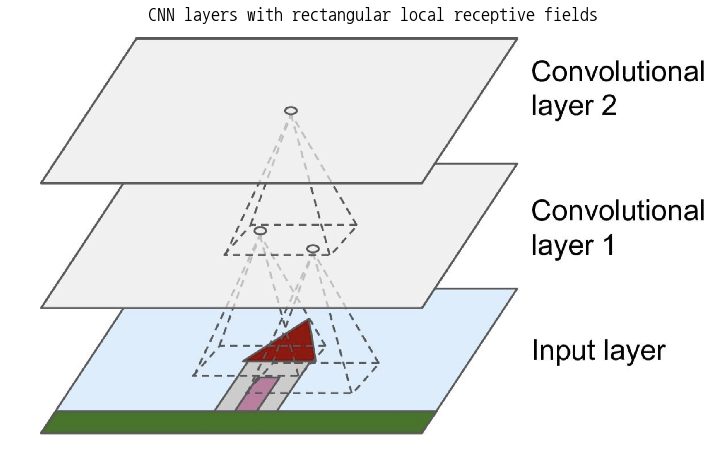

In [2]:
plt.figure(figsize=(12, 8))
plt.title("CNN layers with rectangular local receptive fields", fontsize=18)
plot_external2("./images/cnn/1.png")
plt.show()

2번째 합성곱층에 있는 각 뉴런은 첫 번째 층의 작은 사각 영역 안에 위치한 뉴런에 연결됩니다. 이런 구조는 네트워크가 첫 번째 은닉층에서는 저수준 특성에 집중하고, 그다음 은닉층에서는 고수준 특성으로 조합해 나가도록 도와줍니다. 이런 계층적 구조는 실제 이미지에서 흔히 볼 수 있으며, 이는 CNN이 이미지 인식에 잘 작동하는 이유 중 하나입니다.  

지금까지 살펴본 모든 다층 신경망의 층은 한 줄로 길게 늘어선 뉴런으로 구성되었습니다. 그래서 입력 이미지를 신경망에 주입하기 전에 1D 배열로 펼쳐야 했습니다. 여기서는 각 층이 2D로 표현되므로 뉴런을 그에 상응하는 입력과 연결하기 더 쉽습니다.  

합성곱은 한 함수가 다른 함수 위를 이동하면서 원소별 곱셈의 적분을 계산하는 수학 연산입니다. 이 연산은 푸리에 변환과 라플라스 변환에 깊은 관계가 있으며 신호 처리 분야에서 많이 사용됩니다. 합성곱층은 사실 합성공과 매우 유사한 교차 상관을 사용합니다. 대부분의 딥러닝 프레임워크는 교차 상관으로 구현되어 있습니다.  

어떤 층의 $i$행, $j$열에 있는 한 뉴런은 이전 층의 $i$에서 $i+f_{n}-1$까지의 행과 $j$에서 $j+f_{w}-1$까지 의 열에 있는 뉴런의 출력에 연결됩니다. 여기서 $f_h$와 $f_w$는 이 수용장의 높이와 너비입니다.

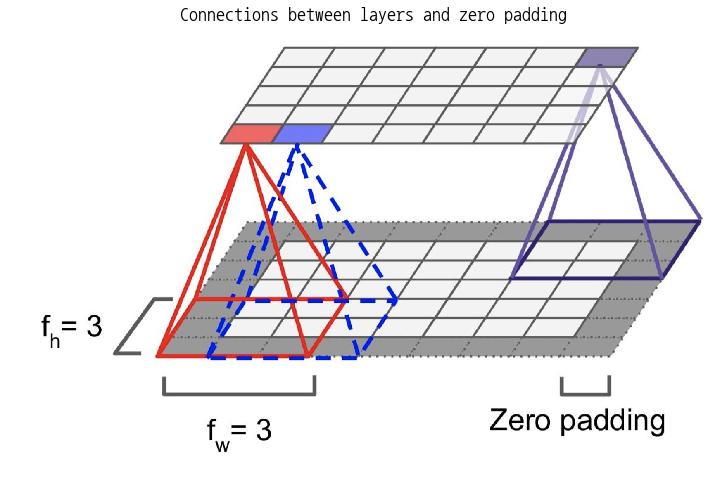

In [4]:
plt.figure(figsize=(12, 8))
plt.title("Connections between layers and zero padding", fontsize=18)
plot_external2("./images/cnn/2.png")
plt.show()

그림에서와 같이 높이와 너비를 이전 층과 같게 하기 위해 입력의 주위에 0을 추가하는 것이 일반적입니다. 이를 **zero padding** 이라 합니다.

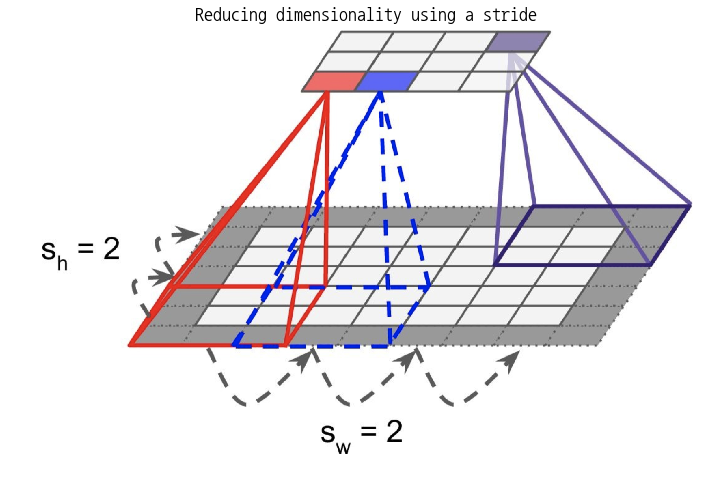

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Reducing dimensionality using a stride", fontsize=18)
plot_external2("./images/cnn/3.png")
plt.show()

위 그림처럼 수용장 사이에 간격을 두어 큰 입력층을 훨씬 작은 층에 연결하는 것도 가능합니다. 연속된 2 개의 수용장 사이의 거리를 ***stride*** 라고 합니다. 이 그림에서는 **zero padding**이 적용된 $5\times 7$입력층이 $3\times 3$ 수용장과 $stride=2$를 사용하여 $3 \times 4$층에 연결되었습니다(이 예제에서는 가로 세로 방향으로 모두 스트라이드가 동일합니다).  상위층의 $i$행, $j$열에 있는 뉴런이 이전 층의 $i \times s_h$ ~ $i \times s_h + f_{h} -1$까지의 행과 $j\times s_w$~$j\times s_w + f_w -1$까지의 열에 위치한 뉴런과 연결됩니다. 여기서 $s_h$와 $s_w$는 스트라이드의 수직값과 수평 값입니다.

<br>
<br>

### 4.1.1 Filters

뉴런의 가중치는 수용장 크기의 작은 이미지로 표현될 수 있습니다. 아래 그림은 **filter**(또는 **convolution kernel**)라 부르는 2개의 가중치 세트를 보여줍니다. 첫 번째 것은 가운데 흰 수직선이 있는 검은 사각형입니다(가운데 열은 $1$로 채워져 있고 그 외에는 모두 0인 $7 \times 7$ 행렬입니다). 이런 가중치를 사용한 뉴런은 가운데 수직선 부분을 제외하고는 수용장에 있는 모든 것을 무시할 것입니다(가운데 위치한 수직선 부분을 제외하고는 입력에 모두 0이 곱해지기 때문에). 두번째 필터는 가운데 흰 수평선이 있는 검은 사각형입니다. 여기에서도 이 가중치를 사용한 뉴런은 가운데 수평선 부분을 제외하고는 수용장 안의 모든 것을 무시할 것입니다.  

아래 그림의 (하단) 입력 이미지를 네트워크에 주입하고 한 층의 모든 뉴런에 같은 수직선 필터를 (그리고 같은 평향을) 적용하면 이 층은 왼쪽 위의 이미지를 출력할 것입니다. 흰 수평선은 강조되고 나머지는 희미해졌습니다. 그러므로 같은 필터를 사용한 전체 뉴런의 층은 필터와 유사한 영역을 강조하는 **feature map**(특성맵)을 만듭니다. 훈련 과정에서 ***CNN***은 해당문제에서 가장 유용한 필터를 찾고 이들을 연결하여 더 복잡한 패턴을 학습합니다(예를 들어 한 이미지에서 십자 표시는 수직 필터와 수평필터가 모두 활성화된 영역입니다).

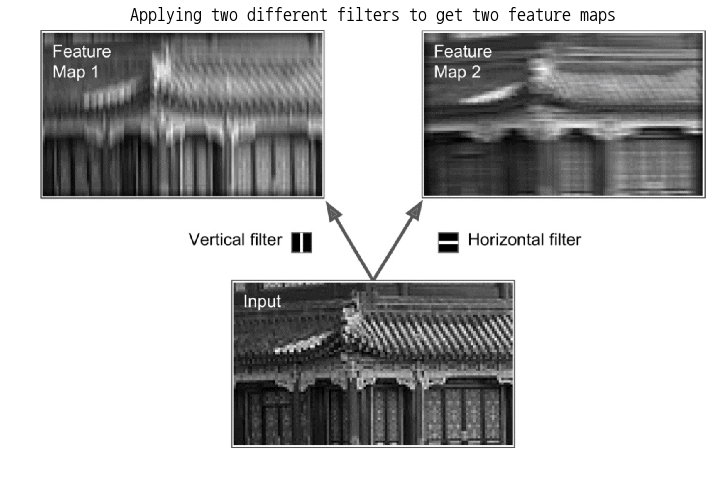

In [6]:
plt.figure(figsize=(12, 8))
plt.title("Applying two different filters to get two feature maps", fontsize=18)
plot_external2("./images/cnn/4.png")
plt.show()

<br><br>

### 4.1.2 Stacking Multiple Feature Maps

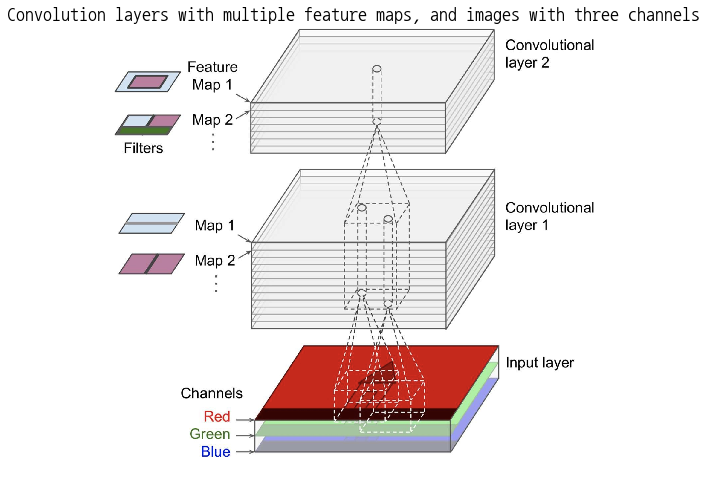

In [8]:
plt.figure(figsize=(12, 8))
plt.title("Convolution layers with multiple feature maps, and images with three channels", fontsize=18)
plot_external2("./images/cnn/5.png")
plt.show()

$$
z_{ i,\, j,\, k }=b_{ k }+\sum _{ u=0 }^{ f_{ h }-1 } \sum _{ v=0 }^{ f_{ w }-1 } \sum _{ k^{ ' }=0 }^{ f_{ n^{ ' } }-1 }{ { x }_{ i^{ ' },\, j^{ ' },\, k^{ ' } }\times { w }_{ u,\, v,\, k^{ ' },\, k } } \qquad where\begin{cases} i^{ ' }=i\times s_{ h }+u \\ j^{ ' }=j\times s_{ w }+v \end{cases}
$$

- $\mathbf{z}_{i,\,j,\,k}$:  합성곱($l$층)의 $k$특성 맵에서 $i$행, $j$열에 위치한 뉴런의 출력  
- $s_{h}$, $s_w$: 수직과 수평 스트라이드  
- $f_h$, $f_w$ : 수용장의 높이와 너비   
- $f_{n^{'}}$: 이전 층($l-1$층에 있는 특성 맵의 수)  
- $x_{ i^{'},\,j^{'},\,k^{'} }$:  $l-1$층의  $i^{'}$행, $j^{'}$열, $k^{'}$ 특성 맵(혹은 $l-1$층이 입력층이면 $k^{'}$채널)  에 있는 뉴런의 출력  
- $b_k$: $l$레이어에 있는 $k$특성 맵의 편향  
- $w_{ u,\,v,\,k^{'},\,k }$: $l$층의 $k$특성 맵에 있는 모든 뉴런과 (뉴런의 수용장에 연관된) $u$행, $v$열, 그리고 $k^{'}$특성맵에 위치한 입력 사이의 연결 가중치  

<br><br>

### 4.1.3 TensorFlow Implementation

> `tf.nn.conv2d()`

- $\mathbf{X}$는 입력의 미니배치(4D 텐서)  
- filters는 적용될 일련의 필터(4D xpstj)  
- strides는 4개의 원소를 갖는 1D 배열, 가운데 2개의 원소는 수직, 수평 스트라이드($s_h$, $s_w$)이고, 현재는 현재는 첫 번째와 마지막 원소가 1이어야 합니다.  
- padding은 "VALID"와 "SAME"중 하나를 지정합니다.  
    - "VALID"로 지정하면 합성곱층에 제로 패딩을 사용하지 않습니다. 아래 그림처럼 stride에 따라 입력 이미지의 아래와 오른쪽 행과 열이 무시될수 있습니다(간단하게 표현하기 위해 여기서는 수평차원만 나타냈지만 같은 로직이 수직 차원에도 적용됩니다).  
    - "SAME"으로 지정하면 합성공층에 제로 패딩을 사용합니다. 이 경우 출력 뉴런 수는 입력 뉴런 수를 스트라이드를 나누어 올림한 것과 같습니다. 그리고 입력 데이터 주변에 가능한 동일하게 0이 추가됩니다.

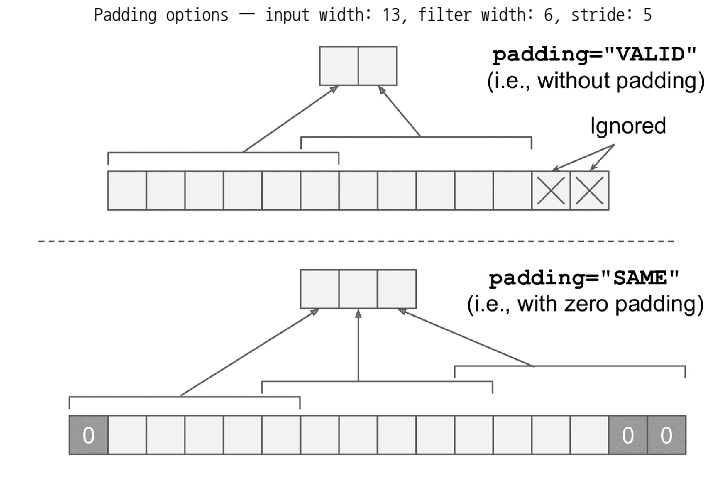

In [16]:
plt.figure(figsize=(12, 8))
plt.title("Padding options — input width: 13, filter width: 6, stride: 5", fontsize=18)
plot_external2("./images/cnn/6.png")
plt.show()

In [13]:
import numpy as np
from sklearn.datasets import load_sample_image

In [14]:
# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [14]:
# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

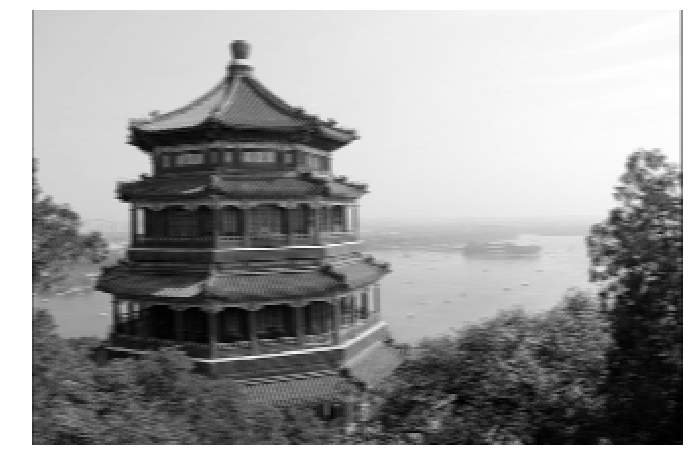

In [15]:
plt.figure(figsize=(12, 8))    
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

> `tf.layers.conv2d()` 사용하기:

이 예에서는 수동으로 필터를 만들었지만, 실제 CNN에서는 훈련 알고리즘이 최선의 필터를 자동으로 탐색합니다. 텐서플로에는 필터 변수를(kernel이란 이름으로) 만들고 랜덤하게 초기화 해주는 tf.layers.conv2d()함수가 있습니다.또한 편향 변수를 (bias란 이름으로)  만들고 0으로 초기화합니다. 예를 들어 다음 코드는 입력 플레이스홀더를 만들고 그 다음에 $7 \times 7$특성 맵으로 $2 \times 2$ 스트라이드 (이 함수에는 수직, 수평 스트라이드만 지정합니다)와 "SAME" 패딩을 사용해 합성곱층을 만듭니다.

In [17]:
import numpy as np
from sklearn.datasets import load_sample_image

In [18]:
# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [19]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [20]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

In [22]:
plt.figure(figszie=(12, 6))
plt.imshow(output[0, :, :, 1], cmap="gray") # 첫 번째 이미지의 두 번째 특성맵 그리기
plt.show()

NameError: name 'figszie' is not defined

<br>
<br>

### 4.1.4 Memory Requirements

***CNN***에 관련된 또 하나의 문제는 역전파 알고리즘이 역방향 계산을 할 때 정방향에서 계산했던 모든 중간 값을 필요로 하기 때문에 특히 훈련하는 동안에 합성곱층이 많은 양의 RAM을 필요로 한다는 점입니다.  

예를들어 $5\times 5$ 필터로 스트라이드 1과 "SAME" 패딩을 사용해 $150 \times 100$크기의 특성 맵 200개를 만드는 합성곱층을 생각해보겠습니다. 입력이 $150\times 100$RGB 이미지(채널 3개)면 파라미터 수는 $(5 \times 5 \times 3 +1) \times 200 = 15,200$개 입니다(+1은 편향). 이 수는 완전 열결 층에 비해 상당히 적습니다(완전연결층 $150\times 100\times 3$입력에 연결된 $150 \times 100$뉴런으로 이루어진 완전 연결 층은 $150^2\times100^2\times3=675,000,000$개의 파라미터). 하지만 200개의 특성 맵마다 $150\times 100$개의 뉴런을 포함하고 있고, 각 뉴런은 $5\times 5 \times 3=75$개의 입력에 대한 가중치 합을 계산해야 합니다. 그러므로 총 225,000,000($5\times 5\times 3(filter\, size) \times 150\times100(feature\, map\, size)\times 200(number\, feature map)=225,000,000$)개의 곱셈이 있습니다. 완전 연결 층 만큼 나쁘지는 않지만 계산량이 너무 많습니다. 더군다나 특성 맵이 32비트 부동소수로 표현된다면 합성곱층의 출력이 RAM의 $200\times 150 \times 32=96,000,000$비트(약 11.4MB)를 점유할 것입니다. 이는 한 샘플에 대해서 입니다. 훈련 배치가 100개의 샘플로 이루어져 있다면 이 층은 1GB의 RAM을 사용할 것입니다.  

추론(inference)을 할 때(즉, 새로운 샘플에 대한 예측을 만들 때)는 하나의 층이 점유하고 있는 RAM은 다음 층의 계산이 완료되자마자 해제될 수 있습니다. 그러므로 연속된 2개의 층에서 필요로 하는 만큼의 RAM만 가지고 있으면 됩니다. 하지만 훈련하는 동안에는 정방향에서 계산했던 모든 값이 역방향을 위해 보존되어야 합니다. 그래서 (적어도) 각 층에서 필요한 RAM양의 전체 합만큼 필요합니다.  

***메모리 부족으로 훈련이 실패한다면 미니배치 크기를 줄여봅니다. 또는 스트라이드를 사용해 차원을 줄이거나 몇 개층을 제거할 수 있습니다. 또는 32비트 부동소수 대신 16비트 부동소수를 사용할 수 있습니다. 아니면 여러 장치에 CNN을 분산시킬 수 있습니다.***

<br>
<br>

## 4.2 Pooling Layer

***pooling layer(풀링층)***의 목적은 계산량과 메모리 사용량, 그리고(과대적합의 위험을 줄여주는)파라미터 수를 줄이기 위해 입력 이미지의 **부표본(subsample)**(즉, 축소본)을 만드는 것입니다. 입력 이미지의 크기를 줄이면 이미지가 약간 이동해도 신경망이 영향을 덜 받습니다(위치 불변성, location invariance).  
합성곱층에서와 마찬가지로 풀링층의 각 뉴런은 이전 층의 작은 사각 영역의 수용장 안에 있는 뉴런의 출력과 연결되어 있습니다. 이전과 동일하게 크기, 스트라이드, 패디 유형을 지정해야 합니다. 하지만 풀링 뉴런은 가중치가 없습니다. 즉, 최대나 평균 같은 합산 함수를 사용해 입력값을 더하는 것이 전부입니다. 아래 그림은 아주 널리 사용되는 풀링층인 **최대 풀링층, max pooling layer**을 보여줍니다. 이 예에서는 $2 \times 2$**풀링 커널, pooling kernel**과 스트라이드 2를 사용하며 패딩은 없습니다. 커널에서 가장 큰 입력 값이 다음 층으로 전달되고 다른 값은 버려집니다.  

확실히 이는 매우 파괴적인 형태의 층입니다. 작은 $2\times 2$커널과 스트라이드 2지만, 출력은 양방향으로 절반이 줄어들어(면적이 1/4로 줄어듬) 입력값의 75%를 잃게 됩니다.  

풀링층은 보통 모든 입력 채널에 독립적으로 적용되기 때문에 출력의 깊이가 입력의 깊이와 동일합니다. 이미지의 공간에 대한 차원(높이와 너비)은 그대로 두고 깊이 차원으로 풀링을 적용해서 채널 수를 줄일 수도 있습니다.

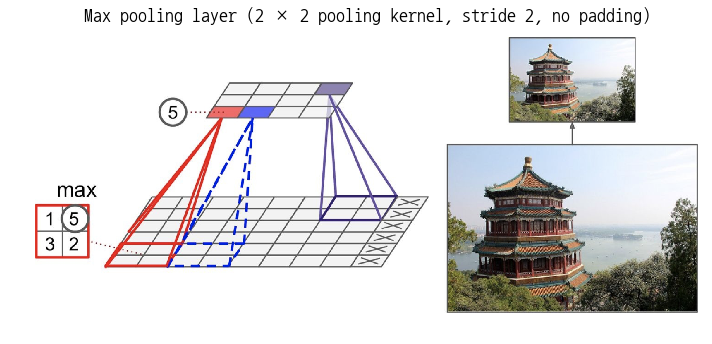

In [24]:
plt.figure(figsize=(12, 8))
plt.title("Max pooling layer (2 × 2 pooling kernel, stride 2, no padding)", fontsize=18)
plot_external2("./images/cnn/7.png")
plt.show()

텐서플로에서 최대풀링층은 다음과 같이 구현합니다($2\times 2$커널, 스트라이드=2, 제로패딩).

In [17]:
import numpy as np
from sklearn.datasets import load_sample_image

In [25]:
# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [32]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

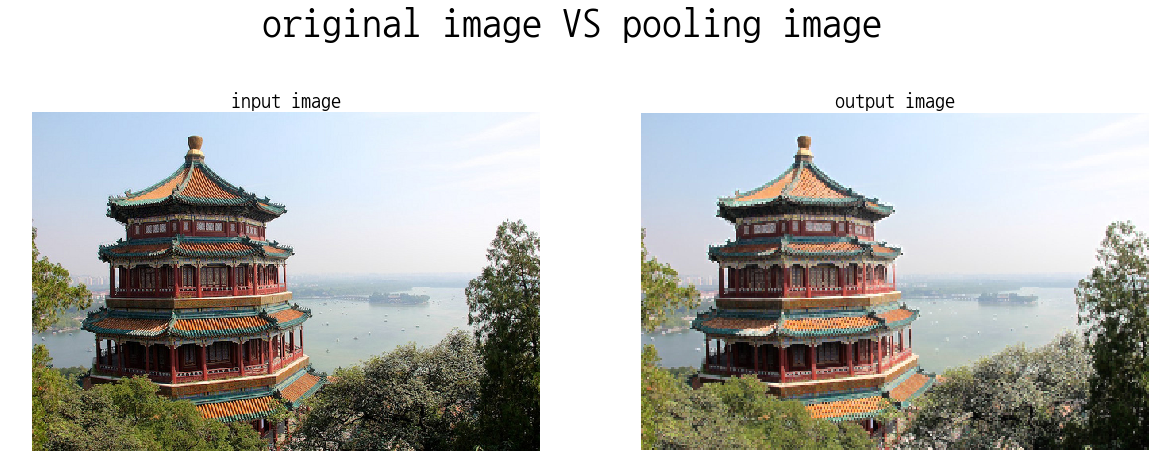

In [43]:
plt.figure(figsize=(20, 8)).suptitle("original image VS pooling image", fontsize=40)
plt.subplot(121)
plt.title("input image", fontsize=20)
plot_color_image(dataset[0])

plt.subplot(122)
plt.title("output image", fontsize=20)
plot_color_image(output[0])
plt.show()

> MNIST

In [157]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

In [159]:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [160]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = mnist_load_data()

In [161]:
n_epochs = 10
batch_size = 100
history = {"val_loss": [], "val_acc": [], 
           "train_loss": [], "train_acc": []}

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in tqdm_notebook(shuffle_batch(X_train, y_train, batch_size), desc="batch"):
            loss_val = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
        
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        
        train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
        val_loss, val_acc = sess.run([loss, accuracy], feed_dict={X: X_valid, y: y_valid})
       
        print(epoch, "배치 데이터 정확도:", train_acc, "검증 세트 정확도:", val_acc, 
              "훈련 세트 오차: ", train_loss, "검증 세트 오차: ", val_loss)

        history["val_loss"].append(val_loss)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
                    
    acc_test = accuracy.eval(feed_dict={X: X_test,
                                        y: y_test})
    print("테스트 세트에서 최종 정확도:", acc_test)
        
    save_path = saver.save(sess, "./models/04_cnn/pooling_layer/my_mnist_model")

0 배치 데이터 정확도: 0.99 검증 세트 정확도: 0.9784 훈련 세트 오차:  0.037500933 검증 세트 오차:  0.07417873


1 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9872 훈련 세트 오차:  0.06365463 검증 세트 오차:  0.0458529


2 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9808 훈련 세트 오차:  0.10738638 검증 세트 오차:  0.06553319


3 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9874 훈련 세트 오차:  0.040530905 검증 세트 오차:  0.04587654


4 배치 데이터 정확도: 0.99 검증 세트 정확도: 0.988 훈련 세트 오차:  0.044093784 검증 세트 오차:  0.042184215


5 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9884 훈련 세트 오차:  0.0112394085 검증 세트 오차:  0.04253733


6 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9888 훈련 세트 오차:  0.006502899 검증 세트 오차:  0.041102476


7 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9886 훈련 세트 오차:  0.00072918215 검증 세트 오차:  0.038979616


8 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9858 훈련 세트 오차:  0.0009370922 검증 세트 오차:  0.053500988


9 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9886 훈련 세트 오차:  0.00060278823 검증 세트 오차:  0.042016674
테스트 세트에서 최종 정확도: 0.9874


In [162]:
acc = history["train_acc"]
val_acc = history["val_acc"]
loss = history["train_loss"]
val_loss = history["val_loss"]

epochs = range(1, len(acc) + 1)

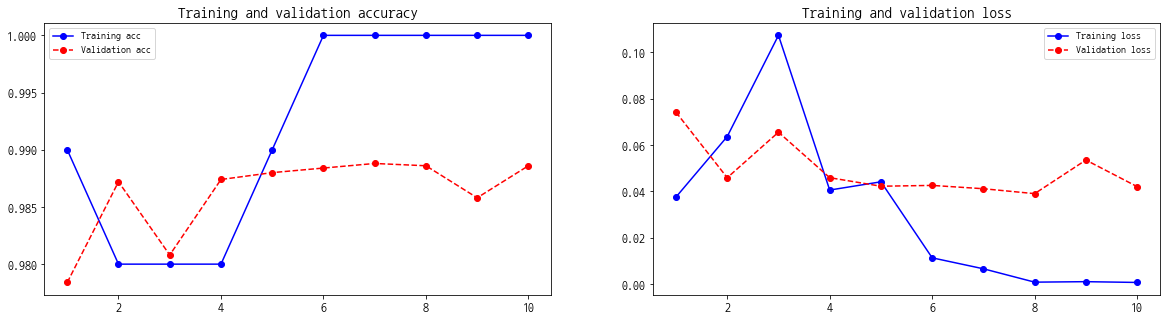

In [169]:
_, fig = plt.subplots(1, 2, figsize=(20, 5))
fig[0].plot(epochs, acc, "bo-", label="Training acc")
fig[0].plot(epochs, val_acc, "ro--", label="Validation acc")
fig[0].set_title("Training and validation accuracy")
fig[0].legend()

fig[1].plot(epochs, loss, "bo-", label="Training loss")
fig[1].plot(epochs, val_loss, "ro--", label="Validation loss")
fig[1].set_title("Training and validation loss")
fig[1].legend()

plt.show()

> MNIST 방법2

## 7. MNIST를 위한 고성능 CNN
_문제: 자신만의 CNN을 만들고 MNIST 데이터셋에서 가능한 최대 정확도를 달성해보세요._

다음 CNN은 위에서 만든 것과 비슷하지만 두 번째 합성곱 층에서 스트라이드 1을 사용하고 두 번째 합성곱 층 뒤에 25% 드롭아웃, 완전 연결층 뒤에 50% 드롭아웃을 적용한 것이 다릅니다. 그리고 조기 종료를 사용하여 훈련합니다. MNIST에서 약 99.2% 정확도를 달성합니다. 최고의 수준은 아니지만 나쁘지 않네요. 더 좋게 만들 수 있을까요?

In [177]:
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [178]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

모델을 훈련시켜 보죠! 조기 종료 구현은 다음과 같이 작동합니다:
* 100번 훈련 반복마다 검증 세트에서 모델을 평가합니다.
* 모델의 성능이 이전에 찾은 최상의 모델보다 낫다면 이 모델을 메모리에 저장합니다.
* 연속해서 100번의 평가 동안에도 진전이 없다면 훈련이 중지됩니다.
* 훈련이 끝난 후에 최상의 모델을 복원합니다.

In [179]:
n_epochs = 100
batch_size = 50
history = {"train_loss": [], "val_loss": [],
           "train_acc": [], "val_acc": []}

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in tqdm_notebook(range(n_batches), desc="batch"):
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                val_loss = loss.eval(feed_dict={X: X_valid, y: y_valid})
                if val_loss < best_loss_val:
                    best_loss_val = val_loss
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        train_acc, train_loss = sess.run([accuracy, loss], feed_dict={X: X_batch, y:y_batch})
        val_acc, val_loss = sess.run([accuracy, loss], feed_dict={X: X_valid, y:y_valid})
#         acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
#         acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("에포크 {}, 배치 데이터 정확도: {:.4f}%, 검증 세트 정확도: {:.4f}%, 검증 세트에서 최선의 손실: {:.6f}".format(
                  epoch, train_acc * 100, val_acc * 100, best_loss_val))
    
        history["val_loss"].append(val_loss)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        if checks_since_last_progress > max_checks_without_progress:
            print("조기 종료!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    # GPU 메모리가 부족해서 5000개만 평가했습니다. CPU를 사용하거나 GPU 메모리가 크다면 테스트 세트 전체를 평가해 보세요.
    acc_test = accuracy.eval(feed_dict={X: X_test[:5000],
                                        y: y_test[:5000]})
    print("테스트 세트에서 최종 정확도:", acc_test)
    save_path = saver.save(sess, "./models/04_cnn/mnist/early_stopping/my_mnist_model")

에포크 0, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.3800%, 검증 세트에서 최선의 손실: 0.052908


에포크 1, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.8800%, 검증 세트에서 최선의 손실: 0.045351


에포크 2, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.8600%, 검증 세트에서 최선의 손실: 0.041169


에포크 3, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.9400%, 검증 세트에서 최선의 손실: 0.035900


에포크 4, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.9400%, 검증 세트에서 최선의 손실: 0.035900


에포크 5, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 98.7600%, 검증 세트에서 최선의 손실: 0.035900


에포크 6, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.0000%, 검증 세트에서 최선의 손실: 0.035900


에포크 7, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.0800%, 검증 세트에서 최선의 손실: 0.035900


에포크 8, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.1200%, 검증 세트에서 최선의 손실: 0.035900


에포크 9, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.0400%, 검증 세트에서 최선의 손실: 0.035900


에포크 10, 배치 데이터 정확도: 100.0000%, 검증 세트 정확도: 99.1200%, 검증 세트에서 최선의 손실: 0.035900
조기 종료!
테스트 세트에서 최종 정확도: 0.9844


In [180]:
acc = history["train_acc"]
val_acc = history["val_acc"]
loss = history["train_loss"]
val_loss = history["val_loss"]

epochs = range(1, len(acc) + 1)

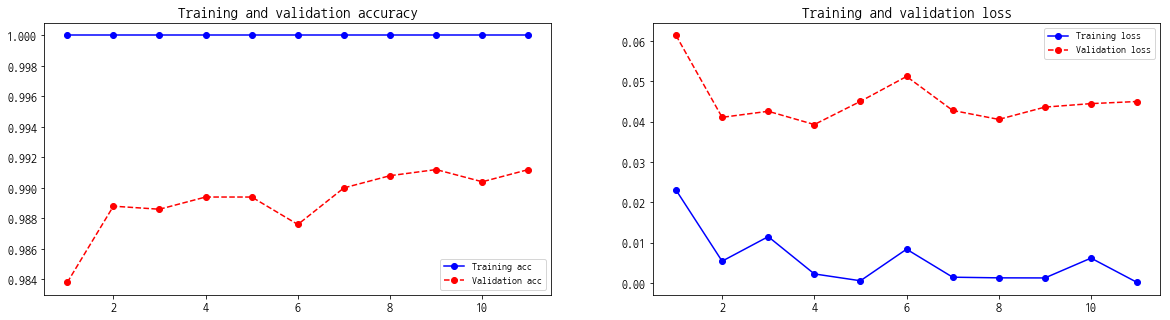

In [181]:
_, fig = plt.subplots(1, 2, figsize=(20, 5))
fig[0].plot(epochs, acc, "bo-", label="Training acc")
fig[0].plot(epochs, val_acc, "ro--", label="Validation acc")
fig[0].set_title("Training and validation accuracy")
fig[0].legend()

fig[1].plot(epochs, loss, "bo-", label="Training loss")
fig[1].plot(epochs, val_loss, "ro--", label="Validation loss")
fig[1].set_title("Training and validation loss")
fig[1].legend()

plt.show()